# Análise dos resultados (V2)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
import colorcet as cc

Definições uteis para outras situações:

In [2]:
%load_ext autoreload
%autoreload 2
from utils import RESULTS_V2_PATH, DATASET_LIST, ABREV_DICT
import utils

## Coletando resultados

In [3]:
csv_files = !ls  $RESULTS_V2_PATH

In [4]:
def get_results_info(file_list: list) -> pd.DataFrame:
    
    results_info = pd.DataFrame(file_list, columns=["file"])
    results_info[["dataset", "split", "learner", "method"]] = results_info.file.str.split("_", n=3, expand=True)
    results_info['file'] = results_info.file.map(lambda x: os.path.join(RESULTS_V2_PATH, x))
    results_info['method'] = results_info.method.apply(lambda x: x.split('.')[0])
    
    return results_info

results_info = get_results_info(csv_files)
results_info.head()

,file,dataset,split,learner,method
0,../results/v2/abalone-3class_1x5_5NN_borderlin...,abalone-3class,1x5,5NN,borderline_points_sampling
1,../results/v2/abalone-3class_1x5_5NN_class_bal...,abalone-3class,1x5,5NN,class_balance_sampling
2,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likelihood_sampling
3,../results/v2/abalone-3class_1x5_5NN_class_lik...,abalone-3class,1x5,5NN,class_likeliood_diff_sampling
4,../results/v2/abalone-3class_1x5_5NN_density_w...,abalone-3class,1x5,5NN,density_weighted_sampling


## Análise de curvas de aprendizado

In [5]:
import seaborn as sns

n_methods = results_info.method.nunique()
color_list = sns.color_palette(cc.glasbey_dark ,n_colors=n_methods)
COLOR_DICT = dict(zip(results_info.method.unique().tolist(), color_list))
COLOR_DICT["random_sampling"] = "firebrick"

In [6]:
def plot_learning_curve(dataset, learner):

    plt.close()
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_ylim(-1,1)
    ax.set_title(f"Average learning curves for AL methods")
    
    
    result_files = results_info[(results_info.learner == learner) & (results_info.dataset == dataset)].file.tolist()

    results_df = pd.concat(pd.read_csv(f) for f in result_files)

    auc_dict = {}
    for method, data in results_df.groupby("method"):
        avg_scores =  data.groupby("query").kappa.mean()
        auc = (np.trapz(avg_scores, avg_scores.index))
        auc_dict[method] = auc

    ranked_method_list = sorted(auc_dict.items(), key=lambda x: x[1],reverse=True)

    i=0
    for method, _ in ranked_method_list:
        avg_curve = results_df[results_df.method == method].groupby("query").kappa.mean()
        ax.plot(avg_curve.rolling(window=5, min_periods=1).mean(),
                utils.get_style(method), linewidth=0.5, color=COLOR_DICT[method], label=ABREV_DICT[method],
            markevery=(0.3, 0.2))
        i+=1
        
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size':8}, framealpha=1)

w.interact(plot_learning_curve,
          dataset=w.SelectionSlider(options=utils.DATASET_LIST),
          learner=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), value="SVC"))

interactive(children=(SelectionSlider(description='dataset', options=('abalone-3class', 'artificial-characters…

<function __main__.plot_learning_curve(dataset, learner)>

## Coleta Resultados

In [7]:
def get_results_df(results_info) -> pd.DataFrame:
    df = pd.concat(pd.read_csv(f) for f in  results_info.file)
    
    return df
    

In [8]:
results_df = get_results_df(results_info)

In [9]:
results_df.head()

,time,dataset,classifier,method,run,fold,query,kappa
0,2025-03-23 18:41:24.629248,abalone-3class,5NN,borderline_points_sampling,0,0,0,0.000000
1,2025-03-23 18:41:29.325717,abalone-3class,5NN,borderline_points_sampling,0,0,1,0.231167
2,2025-03-23 18:41:34.087002,abalone-3class,5NN,borderline_points_sampling,0,0,2,0.314495
3,2025-03-23 18:41:38.828586,abalone-3class,5NN,borderline_points_sampling,0,0,3,0.249614
4,2025-03-23 18:41:43.579852,abalone-3class,5NN,borderline_points_sampling,0,0,4,0.212956


## Plotando Resuldados

### Ranking Curves

In [10]:
def get_avg_ranks(results_df) -> pd.DataFrame:
    # Afere o kappa médio para cada query registrada
    avg_kappa = results_df.groupby(["classifier","method", "query", "dataset"]).apply(lambda x: x.kappa.mean())

    # Afere o rank de cada método para cada dataset
    ranks_df = avg_kappa.to_frame(name="kappa")
    ranks_df['rank'] = ranks_df.groupby(["query", "dataset"]).kappa.rank(ascending=False)

    # Calcula rank médio por query para cada 
    avg_ranks = ranks_df.groupby(["classifier", "method", "query"])["rank"].mean()
    return avg_ranks


In [11]:
avg_ranks_df = get_avg_ranks(results_df)

In [37]:
%matplotlib inline
def plot_learning_curves(avg_ranks_df, classifier):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(True)
    ax.invert_yaxis()
    ax.set_title(classifier)
    

    # Calcula rank médio por query para cada 
    clf_ranks = avg_ranks_df.loc[classifier]
    auc_scores = {}
    for method, data in clf_ranks.groupby("method", sort=False):

        # aplica média móvel nos dados:
        smoothed_data = data.rolling(window=5, min_periods=1).mean()

        auc_scores[ABREV_DICT[method]] = np.trapz(smoothed_data)
        
        ax.plot(smoothed_data.values, utils.get_style(method),
                label=ABREV_DICT.get(method), color=COLOR_DICT[method], markevery=(0.3, 0.2),
                linewidth=(0.5 if utils.get_hm_type(method) != 'Classic' else 1.5) )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}

    sorted_labels = sorted(auc_scores, key=auc_scores.get)
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    plt.show()

w.interact(plot_learning_curves,
           avg_ranks_df=w.fixed(avg_ranks_df),
           classifier=w.ToggleButtons(options=utils.ABREV_MODEL.keys(), description="Leaner:"))


interactive(children=(ToggleButtons(description='Leaner:', options=('GaussianNB', 'SVC', 'DecisionTree', '5NN'…

<function __main__.plot_learning_curves(avg_ranks_df, classifier)>

### Ranking Curves with bands

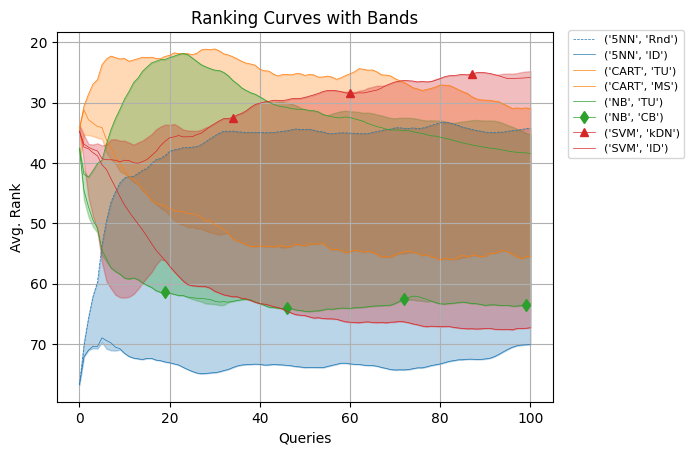

In [13]:
def plot_ranking_curves_with_bands(avg_ranks):

    fig, ax = plt.subplots()
    ax.set_title("Ranking Curves with Bands")
    ax.set_ylabel("Avg. Rank")
    ax.set_xlabel("Queries")
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby(["classifier","method"]).transform( lambda x: x.rolling(window=5, min_periods=1).mean())

    auc_data = smoothed_ranks.groupby(["classifier", "method"]).apply(np.trapz)

    for clf, data in smoothed_ranks.groupby("classifier"):
        worst = auc_data[clf].idxmax()
        best  = auc_data[clf].idxmin()
        
        upper_limmit = smoothed_ranks[clf].groupby("query").max()
        lower_limmit = smoothed_ranks[clf].groupby("query").min()

        
        
        p = ax.plot(smoothed_ranks[clf, best], utils.get_style(best),
                    label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[best]),
                    linewidth=0.5,
                    markevery=(0.3,0.2))
        color = p[0].get_color()
        
        ax.plot(smoothed_ranks[clf, worst], utils.get_style(worst),
                label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[worst]), color=color,
                linewidth=0.5,
                markevery=(0.3,0.2))
        
        ax.fill_between(np.arange(101), upper_limmit, lower_limmit, color=color, alpha=0.3)

    ax.legend(loc="upper left",bbox_to_anchor=(1.02,1.02),ncol=1, prop={'size': 8})

    return 

plot_ranking_curves_with_bands(avg_ranks_df)

### Group Bands

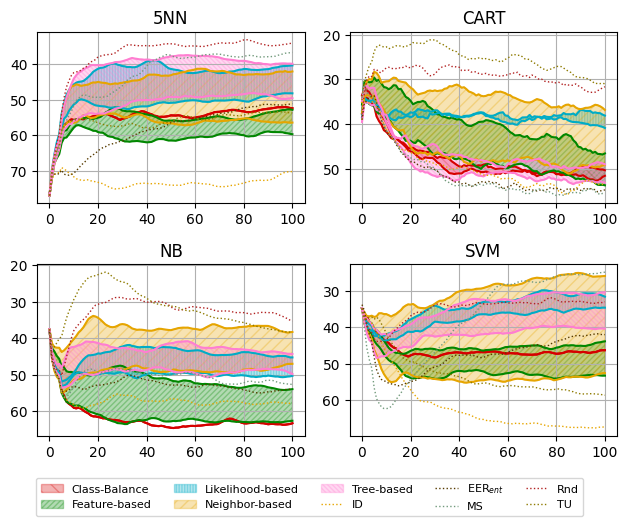

In [14]:
def plot_group_bands(avg_ranks, ax, title=None):

    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby("method").transform( lambda x: x.rolling(window=5, min_periods=1).mean())
    
    df = smoothed_ranks.reset_index()
    df['group'] = df.method.apply(utils.get_hm_type)
    
    color_list = sns.color_palette(cc.glasbey_dark, n_colors=df['group'].nunique())
    i=0
    
    for group, data in df.groupby("group"):

        color = color_list[i]
        i+=1
        
        if group == 'Classic':
                
            continue
            

        min_ranks = data.groupby("query")["rank"].min()
        max_ranks = data.groupby("query")["rank"].max()
        
        ax.plot(max_ranks, color=color)
        ax.plot(min_ranks, color=color)
        ax.fill_between(np.arange(len(min_ranks)), min_ranks, max_ranks,
                        alpha=0.3,color=color, label=group,
                        hatch=utils.get_hm_hatch(group))

    for method, scores in df[df['group'] == 'Classic'].groupby("method", sort=False):
            ax.plot(scores["rank"].values, ':', linewidth=1,
                    label=ABREV_DICT[method], color=COLOR_DICT[method])
        
fig, axs = plt.subplots(2, 2)
for ax, clf in zip(axs.flatten(), sorted(utils.ABREV_MODEL.keys())):
    plot_group_bands(avg_ranks_df[clf], ax, title=utils.ABREV_MODEL[clf])
fig.tight_layout()
plt.legend(loc="lower center",bbox_to_anchor=(-0.15,-0.5),ncol=5, prop={'size': 8})

## AUC

In [43]:
auc_scores = results_df.groupby(["dataset", "classifier", "method", "fold"]).kappa.apply(np.trapz).groupby(["dataset", "classifier", "method"]).mean()

In [45]:
auc_scores.sort_values()

dataset                      classifier    method                      
eeg-eye-state                DecisionTree  margin_sampling                 -4.671517
                                           tree_depth_pruned_sampling      -4.485758
                                           class_balance_sampling          -4.425079
                                           tree_depth_unpruned_sampling    -4.357125
banana                       GaussianNB    training_utility_sampling       -4.348413
                                                                             ...    
wine                         SVC           f1_sampling                     94.641748
robot-nav-sensor-readings-2  DecisionTree  training_utility_sampling       94.782997
wine                         SVC           f4_sampling                     95.207394
                                           f3_sampling                     95.261107
banknote-authentication      SVC           ls_radius_sampling              95.

In [46]:
from scipy.stats import friedmanchisquare

In [89]:
# Classificador 1 (Coluna 1)
clf1 = [
    0.763,  # adult (sample)
    0.599,  # breast cancer
    0.954,  # breast cancer wisconsin
    0.628,  # cmc
    0.882,  # ionosphere
    0.936,  # iris
    0.661,  # liver disorders
    0.583,  # lung cancer
    0.775,  # lymphography
    1.000,  # mushroom
    0.940,  # primary tumor
    0.619,  # rheum
    0.972,  # voting
    0.957   # wine
]

# Classificador 2 (Coluna 2)
clf2 = [
    0.768,  # adult (sample)
    0.591,  # breast cancer
    0.971,  # breast cancer wisconsin
    0.661,  # cmc
    0.888,  # ionosphere
    0.931,  # iris
    0.668,  # liver disorders
    0.583,  # lung cancer
    0.838,  # lymphography
    1.000,  # mushroom
    0.962,  # primary tumor
    0.666,  # rheum
    0.981,  # voting
    0.978   # wine
]

# Classificador 3 (Coluna 3)
clf3 = [
    0.771,  # adult (sample)
    0.590,  # breast cancer
    0.968,  # breast cancer wisconsin
    0.654,  # cmc
    0.886,  # ionosphere
    0.916,  # iris
    0.609,  # liver disorders
    0.563,  # lung cancer
    0.866,  # lymphography
    1.000,  # mushroom
    0.965,  # primary tumor
    0.614,  # rheum
    0.975,  # voting
    0.946   # wine
]

# Classificador 4 (Coluna 4)
clf4 = [
    0.798,  # adult (sample)
    0.569,  # breast cancer
    0.967,  # breast cancer wisconsin
    0.657,  # cmc
    0.898,  # ionosphere
    0.931,  # iris
    0.685,  # liver disorders
    0.625,  # lung cancer
    0.875,  # lymphography
    1.000,  # mushroom
    0.962,  # primary tumor
    0.669,  # rheum
    0.975,  # voting
    0.970   # wine
]


In [90]:
friedmanchisquare(clf1, clf2, clf3, clf4)

FriedmanchisquareResult(statistic=10.952380952380956, pvalue=0.011986176325417788)